<a href="https://colab.research.google.com/github/edcalderin/LLM_Tech/blob/master/Feature_Engineering_With_Latitude_and_Longitude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering With Latitude and Longitude

https://medium.com/data-science/feature-engineering-with-latitude-and-longitude-2577b7ad7a45

Feature engineering experiments:
1. Raw latitude and longitude
2. Spatial density
3. Geohash target encoding
4. Combination of all features

Load data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deepcontractor/miami-housing-dataset")

print("Path to dataset files:", path)

100%|██████████| 650k/650k [00:00<00:00, 32.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/deepcontractor/miami-housing-dataset/versions/3


In [2]:
!ls $path

miami-housing.csv


In [3]:
import pandas as pd
from pathlib import Path

df = pd.read_csv(Path(path)/"miami-housing.csv")
df.head()

,LATITUDE,LONGITUDE,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,25.891031,-80.160561,622280070620,440000.0,9375,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67,0,8,4
1,25.891324,-80.153968,622280100460,349000.0,9375,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63,0,9,4
2,25.891334,-80.153740,622280100470,800000.0,9375,2276,49206,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61,0,2,4
3,25.891765,-80.152657,622280100530,988000.0,12450,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63,0,9,4
4,25.891825,-80.154639,622280100200,755000.0,12800,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42,0,7,4


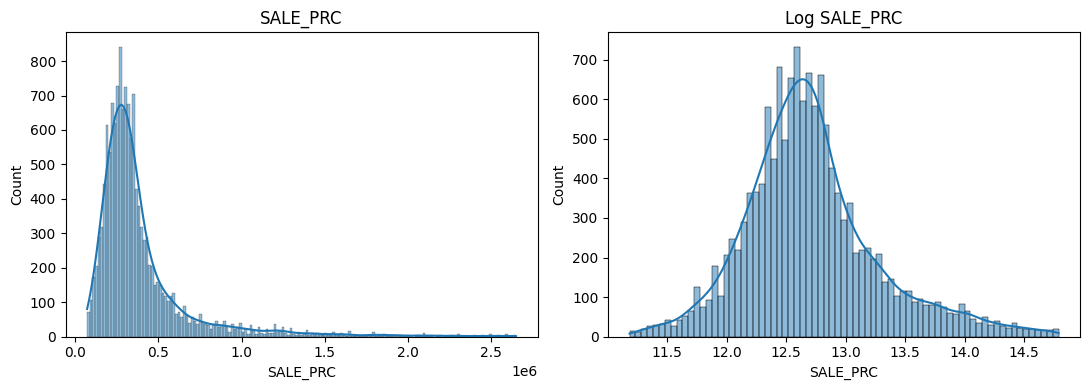

In [33]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 4))

plt.subplot(1,2,1)
sns.histplot(df["SALE_PRC"], kde=True)
plt.title("SALE_PRC")

plt.subplot(1,2,2)
sns.histplot(np.log(df["SALE_PRC"]), kde=True)
plt.title("Log SALE_PRC")

plt.tight_layout()
plt.show()

## Feature Engineering

In [132]:
from sklearn.model_selection import train_test_split

FEATURES: list[str] = ["LATITUDE", "LONGITUDE"]
TARGET: str = "SALE_PRC"

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.log(y_train)
y_test = np.log(y_test)

### 1. Raw Lat Long

In [133]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

model_classes: list[str] = [Ridge, XGBRegressor]

def fit_and_report(
        train_dataset: pd.DataFrame,
        test_dataset: pd.DataFrame,
        y_train: pd.Series,
        y_test: pd.Series)->dict:
    results = {}
    for model_class in model_classes:
        model = model_class()
        model.fit(train_dataset, y_train)
        y_pred = model.predict(test_dataset)
        rmse = root_mean_squared_error(y_test, y_pred)
        results[model.__class__.__name__] = rmse
    return results

report = {"Raw_lat_lon": fit_and_report(X_train[FEATURES], X_test[FEATURES], y_train, y_test)}

pd.DataFrame(report).T

,Ridge,XGBRegressor
Raw_lat_lon,0.564645,0.251429


## Spatial Density

In [134]:
from scipy.spatial import cKDTree

def get_density_feature(df: pd.DataFrame) -> pd.DataFrame:
    tree = cKDTree(df)
    return tree.query_ball_point(df, r=0.005, return_length=True)

X_train["spatial_density"] = get_density_feature(X_train)
X_test["spatial_density"] = get_density_feature(X_test)

report["spatial_density"] = fit_and_report(X_train[["spatial_density"]],
                                           X_test[["spatial_density"]],
                                           y_train,
                                           y_test)

pd.DataFrame.from_records(report).T

,Ridge,XGBRegressor
Raw_lat_lon,0.564645,0.251429
spatial_density,0.567823,0.597206


## Geohash

In [79]:
!pip install -q geohash2

  Preparing metadata (setup.py) ... done


In [135]:
import geohash2
from sklearn.preprocessing import OneHotEncoder

def get_geohash_value(df: pd.DataFrame) -> pd.Series:
    return df.apply(lambda row: geohash2.encode(
        row['LATITUDE'], row['LONGITUDE'], precision=5), axis=1)

X_train["geohash"] = get_geohash_value(X_train)
X_test["geohash"] = get_geohash_value(X_test)

ohe = OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False)
geohash_ohe_train = ohe.fit_transform(X_train[["geohash"]])
geohash_ohe_test = ohe.transform(X_test[["geohash"]])

report["geohash"] = fit_and_report(
    geohash_ohe_train,
    geohash_ohe_test,
    y_train,
    y_test
)

pd.DataFrame.from_records(report).T

,Ridge,XGBRegressor
Raw_lat_lon,0.564645,0.251429
geohash,0.365206,0.365136
spatial_density,0.567823,0.597206


## 4. Putting It All Together

In [136]:
X_train_all = pd.concat([X_train[FEATURES + ["spatial_density"]], pd.DataFrame(geohash_ohe_train, index=X_train.index)], axis=1)
X_test_all = pd.concat([X_test[FEATURES + ["spatial_density"]], pd.DataFrame(geohash_ohe_test, index=X_test.index)], axis=1)
X_train_all.columns = X_train_all.columns.astype(str)
X_test_all.columns = X_test_all.columns.astype(str)

In [137]:
report["all_features"] = fit_and_report(
    X_train_all,
    X_test_all,
    y_train,
    y_test
)

pd.DataFrame.from_records(report).T

,Ridge,XGBRegressor
Raw_lat_lon,0.564645,0.251429
all_features,0.368830,0.292521
geohash,0.365206,0.365136
spatial_density,0.567823,0.597206


* Best XGBRegressor performance is with `Raw_lat_lon` (`RMSE = 0.2514`), indicating that raw latitude and longitude alone are highly informative for tree-based models like XGBoost.

* Best Ridge performance is with `geohash` (`RMSE = 0.3652`), showing that this feature representation aligns well with linear models.

* The worst XGBRegressor performance is with `spatial_density` (`RMSE = 0.5972`), and for Ridge it’s with `raw_lat_lon` (`RMSE = 0.5646`).

* `all_features` are competitive in both models, but not the best in either.